# Value Function Approximation

Notes from this [lecture](https://www.youtube.com/watch?v=UoPei5o4fps&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ&index=6)

Slides are [here](https://davidstarsilver.wordpress.com/wp-content/uploads/2025/04/lecture-6-value-function-approximation-.pdf).



- So far we looked at the value function as a look up table
- There are too many states / actions
- Solution, approximate the value function, estimate v everywhere


$$
\hat{v}(s, \mathbf{w}) \approx v_{\pi}(s)\\
\hat{q}(s, a, \mathbf{w}) \approx q_{\pi}(s, a)
$$

- We could use any function approximater, examples: Neural Networks, decision trees, linear combinations of features.
- The training data need to be non-stationary, non-iid data
- could use gradient descent

## Initial setup

We'll use [`gymnasium`](https://gymnasium.farama.org/) for creating enviroments that we could use to test various algorithms.

Here is some boilerplate code that helps us train any policy:

In [71]:
def train(env, choose_action, Q_values, update_w, gamma, epsilon, epsilon_decay, epsilon_min,
          num_episodes, verbose=False):

    reward_history = []

    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = choose_action(state, epsilon)

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            total_reward += reward

            # Compute target
            if done:
                td_target = reward
            else:
                td_target = reward + gamma * np.max(Q_values(next_state))

            # TD error
            td_error = td_target - Q_values(state)[action]

            # Gradient update:

            update_w(td_error, state, action)

            state = next_state

        # Epsilon decay
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        reward_history.append(total_reward)
        if verbose:
            print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")
    return reward_history

## Mountain Car Example

Let's try playing around with the mountain car example.

See documation for this example here https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/

Here we approximate the value function as linear mapping from the state:

$$
Q(s, a) = W[a]^T \cdot s
$$

Let's try that with the mountain car example:

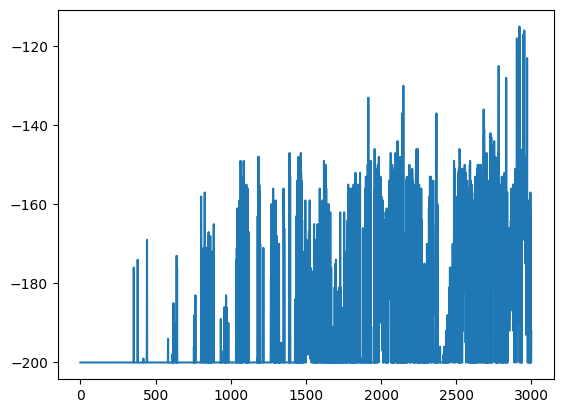

In [121]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import copy


# ----------------------
# Hyperparameters
# ----------------------
alpha = 0.1          # learning rate
gamma = 0.99          # discount
epsilon = 1.0         # exploration
epsilon_min = 0.05
epsilon_decay = 0.995
num_episodes = 3000

# ----------------------
# Environment
# ----------------------
env = gym.make("MountainCar-v0")

res_p = 0.1
res_v = 0.01

state_low = env.observation_space.low
state_high = env.observation_space.high
n_actions = env.action_space.n

p_range =  state_high[0] - state_low[0] 
v_range =  state_high[1] - state_low[1] 

n_p = int(p_range / res_p) + 1
n_v = int(v_range / res_v) + 1

Q = np.zeros(shape=(n_p * n_v, n_actions))

def Q_index(state):
    index_p = int((state[0] - state_low[0]) / res_p)
    index_v = int((state[1] - state_low[1]) / res_v)
    return index_p * (n_v) + index_v


# Q[Q_index([state_high[0], state_high[1]], 2)] = 1;

def Q_values(s):
    """Return Q(s, :) for all actions."""
    return Q[Q_index(s)]

def choose_action(state, epsilon):
    """Epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q_values(state))

def update_w(td_error, state, action):
    # Q = w_a^T s  → grad = s
    Q[Q_index(state)][action] += alpha * td_error

reward_history = train(env, choose_action, Q_values, update_w, gamma, epsilon, epsilon_decay, epsilon_min, num_episodes)

env.close()
plt.plot(reward_history)

In [74]:
import gymnasium as gym
import numpy as np
import imageio.v3 as iio


def render_policy(Q_values, video_name):

    frames = []

    render_env = gym.make("MountainCar-v0", render_mode="rgb_array")

    state, info = render_env.reset()
    done = False

    def select_action(state):
        return np.argmax(Q_values(state))

    while not done:
        # Greedy action using your linear policy (replace with your function)
        action = select_action(state)

        next_state, reward, terminated, truncated, info = render_env.step(action)
        done = terminated or truncated

        frame = render_env.render()   # RGB array frame
        frames.append(frame)

        state = next_state

    render_env.close()


    # Save frames to MP4 using imageio
    iio.imwrite(
        video_name,
        frames,
        fps=30,
        codec="libx264"
    )



render_policy(Q_values, "mountain_car_tabular.mp4")
print(f"Saved to {video_name}")
from IPython.display import Video
Video("mountain_car_tabular.mp4", embed=True)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved to cartpole_tabular.mp4


In [85]:
# Tile coding parameters
num_tilings = 8      # number of overlapping tilings
tiles_per_dim = 8    # tiles along each dimension

# ----------------------
# Environment
# ----------------------
env = gym.make("MountainCar-v0")
state_low = env.observation_space.low
state_high = env.observation_space.high
n_actions = env.action_space.n

# ----------------------
# Tile coding setup
# ----------------------
def tile_encode(state):
    """Return a binary feature vector using multiple tilings."""
    features = np.zeros(num_tilings * tiles_per_dim * tiles_per_dim)
    for tiling in range(num_tilings):
        # Compute offsets
        offsets = (tiling / num_tilings) * (state_high - state_low) / tiles_per_dim
        coords = ((state - state_low + offsets) * tiles_per_dim / (state_high - state_low)).astype(int)
        coords = np.clip(coords, 0, tiles_per_dim - 1)
        index = tiling * tiles_per_dim * tiles_per_dim + coords[0] * tiles_per_dim + coords[1]
        features[index] = 1
    return features

num_features = num_tilings * tiles_per_dim * tiles_per_dim

# ----------------------
# Linear weights: one vector per action
# ----------------------
W = np.zeros((n_actions, num_features))

# ----------------------
# Q function
# ----------------------
def Q_values(s):
    features = tile_encode(s)
    return W @ features

# ----------------------
# Epsilon-greedy action
# ----------------------
def choose_action(s, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q_values(s))

def update_w(td_error, state, action):
    # TD update
    features = tile_encode(state)
    W[action] += alpha * td_error * features
    

[[-4.68116737 -4.9059904  -5.47973363 ... -3.55494628 -1.78553502
  -0.95730505]
 [-4.52882036 -5.34231276 -5.72204489 ... -1.8216197  -2.24617618
  -1.7484784 ]
 [-4.1228593  -5.67757371 -4.87371314 ... -3.27193173 -0.41030111
  -0.38990922]]


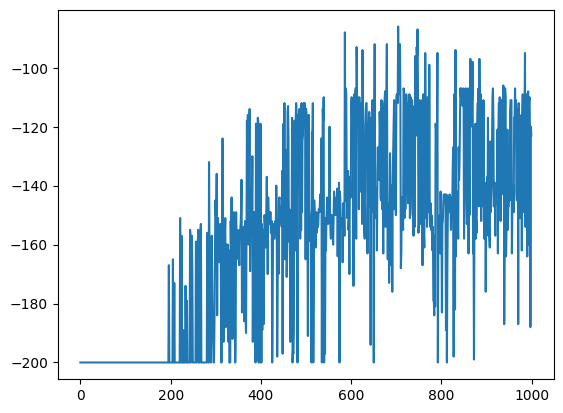

In [86]:
# ----------------------
# Hyperparameters
# ----------------------
alpha = 0.05          # learning rate
gamma = 0.99          # discount
epsilon = 1.0         # exploration
epsilon_min = 0.05
epsilon_decay = 0.995
num_episodes = 1000


reward_history = train(env, choose_action, Q_values, update_w, gamma, epsilon, epsilon_decay, epsilon_min, num_episodes)

env.close()

print(W)
plt.plot(reward_history)

In [87]:
render_policy(Q_values, "mountain_car_cmac.mp4")
print(f"Saved to {video_name}")
from IPython.display import Video
Video("mountain_car_cmac.mp4", embed=True)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved to cartpole_tabular.mp4


## DQN Example


In [117]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

# Define model
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)   # first fully connected layer
        self.out = nn.Linear(h1_nodes, out_actions) # ouptut layer w

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Apply rectified linear unit (ReLU) activation
        x = self.out(x)         # Calculate output
        return x

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

# MountainCar Deep Q-Learning
class MountainCarDQL():
    # Hyperparameters (adjustable)
    learning_rate_a = 0.05         # learning rate (alpha)
    discount_factor_g = 0.9         # discount rate (gamma)    
    network_sync_rate = 50000          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 100000       # size of replay memory
    mini_batch_size = 32            # size of the training data set sampled from the replay memory

    num_divisions = 20

    # Neural Network
    loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None                # NN Optimizer. Initialize later.


    # Train the environment
    def train(self, episodes, render=False):
        # Create FrozenLake instance
        env = gym.make('MountainCar-v0', render_mode='human' if render else None)
        num_states = env.observation_space.shape[0] # expecting 2: position & velocity
        num_actions = env.action_space.n

        # Divide position and velocity into segments
        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07
    
        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions)

        # Make the target and policy networks the same (copy weights/biases from one network to the other)
        target_dqn.load_state_dict(policy_dqn.state_dict())
        
        # Policy network optimizer. "Adam" optimizer can be swapped to something else. 
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        # List to keep track of rewards collected per episode. Initialize list to 0's.
        rewards_per_episode = []

        # List to keep track of epsilon decay
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0
        goal_reached=False
        best_rewards=-10000000
            
        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal

            rewards = 0

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and rewards>-1000):

                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample() # actions: 0=left,1=idle,2=right
                else:
                    # select best action            
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                new_state,reward,terminated,truncated,_ = env.step(action)

                # Accumulate reward
                rewards += reward

                # Save experience into memory
                memory.append((state, action, new_state, reward, terminated)) 

                # Move to the next state
                state = new_state

                # Increment step counter
                step_count+=1

            # Keep track of the rewards collected per episode.
            rewards_per_episode.append(rewards)
            if(terminated):
                goal_reached = True

            # Graph training progress
            if(i!=0 and i%1000==0):
                print(f'Episode {i} Epsilon {epsilon}')
                                        
                self.plot_progress(rewards_per_episode, epsilon_history)
            
            if rewards > best_rewards:
                best_rewards = rewards
                print(f'Best rewards so far: {best_rewards}')
                # Save policy
                torch.save(policy_dqn.state_dict(), f"mountaincar_dql.pt")
            
            
            epsilon = max(epsilon - 1/episodes, 0)
            # Decay epsilon
            epsilon_history.append(epsilon)
            
            # Check if enough experience has been collected
            if len(memory)>self.mini_batch_size and goal_reached:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)        

 

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0                    

        # Close environment
        env.close()
    def plot_progress(self, rewards_per_episode, epsilon_history):
        # Create new graph 
        plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        # rewards_curve = np.zeros(len(rewards_per_episode))
        # for x in range(len(rewards_per_episode)):
            # rewards_curve[x] = np.min(rewards_per_episode[max(0, x-10):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        # plt.plot(sum_rewards)
        plt.plot(rewards_per_episode)
        
        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)
        
        # Save plots
        plt.savefig('mountaincar_dql.png')
    # Optimize policy network
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:

            if terminated: 
                # Agent receive reward of 0 for reaching goal.
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value 
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state)).max()
                    )

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state)) 
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)
                
        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    '''
    Converts a state (position, velocity) to tensor representation.
    Example:
    Input = (0.3, -0.03)
    Return = tensor([16, 6])
    '''
    def state_to_dqn_input(self, state)->torch.Tensor:
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)
        
        return torch.FloatTensor([state_p, state_v])
    
    # Run the environment with the learned policy
    def test(self, episodes, model_filepath, video_name):
        # Create FrozenLake instance
#         env = gym.make('MountainCar-v0', render_mode='human')
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        # Load learned policy
        policy_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions) 
        policy_dqn.load_state_dict(torch.load(model_filepath))
        policy_dqn.eval()    # switch model to evaluation mode

#         for i in range(episodes):
#             state = env.reset()[0]  # Initialize to state 0
#             terminated = False      # True when agent falls in hole or reached goal
#             truncated = False       # True when agent takes more than 200 actions            

#             # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
#             while(not terminated and not truncated):  
#                 # Select best action   
#                 with torch.no_grad():
#                     action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

#                 # Execute action
#                 state,reward,terminated,truncated,_ = env.step(action)

#         env.close()


        
        
        frames = []

        render_env = gym.make("MountainCar-v0", render_mode="rgb_array")

        state, info = render_env.reset()
        done = False

        def select_action(state):
            return policy_dqn(self.state_to_dqn_input(state)).argmax().item()

        while not done:
            # Greedy action using your linear policy (replace with your function)
            action = select_action(state)

            next_state, reward, terminated, truncated, info = render_env.step(action)
            done = terminated or truncated

            frame = render_env.render()   # RGB array frame
            frames.append(frame)

            state = next_state

        render_env.close()


        # Save frames to MP4 using imageio
        iio.imwrite(
            video_name,
            frames,
            fps=30,
            codec="libx264"
        )


Best rewards so far: -1000.0
Best rewards so far: -879.0
Episode 1000 Epsilon 0.800000000000022
Best rewards so far: -820.0
Best rewards so far: -694.0
Episode 2000 Epsilon 0.600000000000044
Episode 3000 Epsilon 0.4000000000000661
Best rewards so far: -531.0
Episode 4000 Epsilon 0.20000000000008117
Best rewards so far: -378.0
Best rewards so far: -265.0
Best rewards so far: -229.0


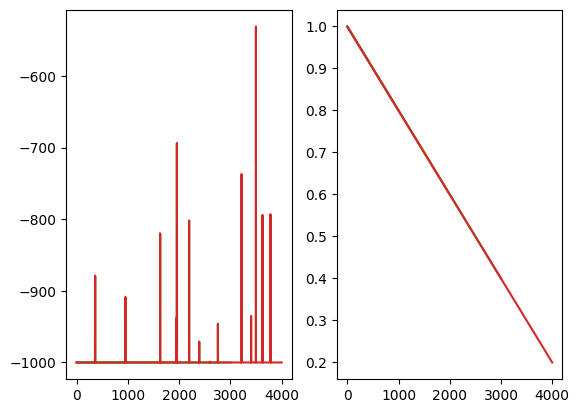

In [118]:

mountaincar = MountainCarDQL()
mountaincar.train(5000, False)


In [119]:
mountaincar = MountainCarDQL()
mountaincar.test(10, "/app/knowledge_compendium/machine_learning/reinforcement_learning/mountaincar_dql.pt", "mountain_car_dqn.mp4")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [120]:
print(f"Saved to {video_name}")
from IPython.display import Video
Video("mountain_car_dqn.mp4", embed=True)

Saved to cartpole_tabular.mp4
